In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.stats import multivariate_normal
from jax.scipy.special import logsumexp
from jax.tree_util import tree_structure

In [3]:
import genjax
console = genjax.pretty()

In [4]:
import gi

In [5]:
normalize = lambda xs: xs / xs.sum()
normalize_logs = lambda lxs: lxs - logsumexp(lxs)
log_normalize = lambda xs: jnp.log(xs) - jnp.log(xs.sum())

In [6]:
key = jax.random.PRNGKey(2718)

In [7]:
N = 5 # oy
@genjax.gen
def model(xmean: float, ymean: float, posvar: float, obsvar: float):
    x = genjax.normal(xmean, posvar) @ 'x'
    y = genjax.normal(ymean, posvar) @ ('weirdness', 'y')
    obs_mean = jnp.array([x, y])
    for i in range(N):
        genjax.mv_normal(obs_mean, obsvar * jnp.eye(2)) @ ('obs', i)

In [8]:
XMEAN, YMEAN, POSVAR, OBSVAR =  0.0, 0.0, 10.0, 4.0

In [9]:
tr = model.simulate(key, (XMEAN, YMEAN, POSVAR, OBSVAR))

In [10]:
def viz_posterior(ax, obss, pos=None, show_obs=True):
    var = POSVAR * OBSVAR / (OBSVAR + N*POSVAR)  # posterior var
    mean = var * (jnp.array([XMEAN, YMEAN])/POSVAR + obss.sum(axis=0) / OBSVAR) # posterior mean
    logpdf = gi.multivmap(lambda x, y: genjax.mv_normal.logpdf(jnp.array([x, y]), mean, var * jnp.eye(2)))
    imxs = jnp.linspace(mean[0]-2*OBSVAR, mean[0]+2*OBSVAR, 100)
    imys = jnp.linspace(mean[1]-2*OBSVAR, mean[1]+2*OBSVAR, 100)
    ax.set_xlim(7, 24)
    ax.set_ylim(6, 22)
    img = jnp.exp(logpdf(imxs, imys))
    ax.imshow(img, extent=(7, 24, 6, 22), origin='lower')
    if show_obs:
        ax.scatter(obss[:, 0], obss[:, 1], marker='o', c='r')
    if pos is not None:
        ax.scatter([pos[0]], [pos[1]], marker='o', c='w')

In [11]:
obss = jnp.array([tr[('obs', i)] for i in range(N)])

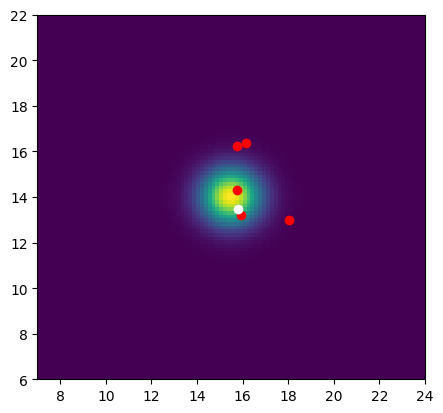

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
viz_posterior(ax, obss, pos=[tr['x'], tr[('weirdness', 'y')]])

In [13]:
init_trp = gi.TracePartition.from_trace(tr,
    {'x': gi.RegularIntervalPartition(7, 24, 10),
    ('weirdness', 'y'): gi.RegularIntervalPartition(6, 22, 10)})

scoring_strats = [
    gi.TraceScoringStrategy({
        'x': gi.IntervalQuadrature(4),
        ('weirdness', 'y'): gi.IntervalQuadrature(3)
    }),
    
    gi.TraceScoringStrategy({
        'x': gi.IntervalQuadrature(2),
        ('weirdness', 'y'): gi.IntervalQuadrature(2)
    })
]

refinement_strats = [
    gi.TraceRefinementStrategy({
        'x': gi.IntervalEquidissection(3),
        ('weirdness', 'y'): gi.IntervalEquidissection(2)
    })
]

In [14]:
strat = gi.C2FStrategy(init_trp, refinement_strats, scoring_strats)

In [15]:
sampler = gi.C2FSampler(model, (XMEAN, YMEAN, POSVAR, OBSVAR), strat) 

In [16]:
def viz_trp(ax, trp):
    xpart, ypart = trp['x'], trp[('weirdness', 'y')]
    ax.set_xticks(xpart.part_pts)
    ax.set_yticks(ypart.part_pts)
    ax.vlines(xpart.part_pts, ypart.left, ypart.right, color='grey')
    ax.hlines(ypart.part_pts, xpart.left, xpart.right, color='grey')

In [17]:
def viz_scoring(ax, trp, scoring_strat):
    viz_trp(ax, trp)
    xsgrid, ysgrid = jnp.meshgrid(*scoring_strat.get_scoring_pts(trp))
    ax.scatter(xsgrid.flatten(), ysgrid.flatten(), color='r', marker='o', s=1)

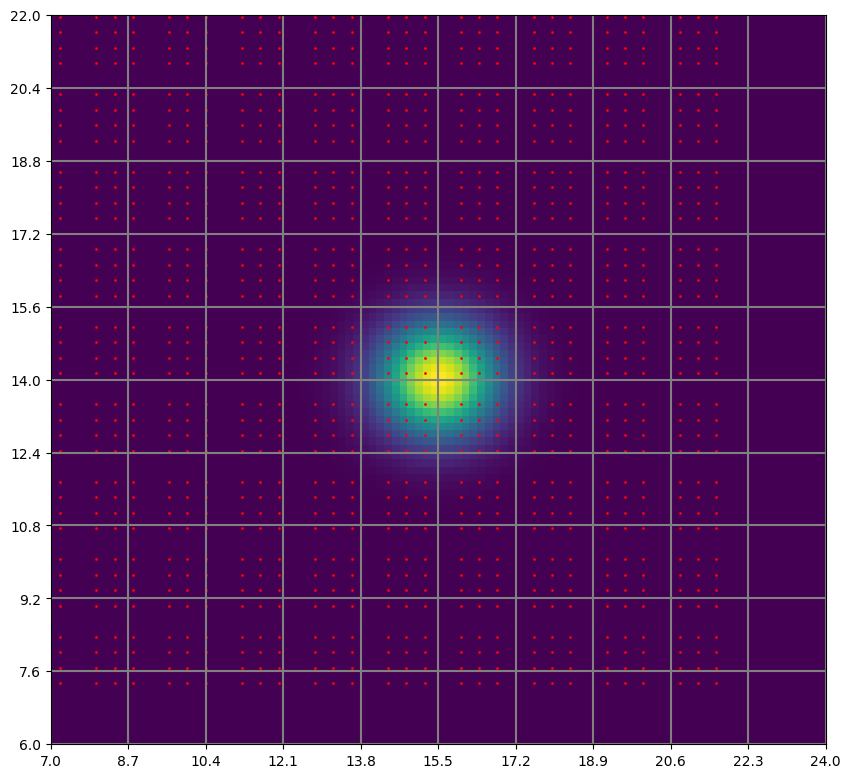

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
viz_posterior(ax, obss, show_obs=False)
viz_scoring(ax, init_trp, scoring_strats[0])

In [19]:
sampler_jit = jax.jit(sampler.sample)

In [20]:
ch = sampler_jit(key)
key = jax.random.split(key, 1)[0]
ch['x'], ch[('weirdness', 'y')]

(Array(17.868315, dtype=float32), Array(14.572154, dtype=float32))